In [24]:
#setup
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import display
from pprint import pprint
from unidecode import unidecode
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,8)
pd.options.mode.chained_assignment = None #disable a specific warning when writing on a copy of a df 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Creating the csv

In [25]:
from main import nlp_pipeline_result

# data = nlp_pipeline_result(
#     parser_parameters={
#         "remove_hashtag_word": True,
#         "replace_politics": True,
#         "replace_parties": True,
#     },
#     nlp_parameters={
#         "disable_parser": True,
#         "disable_ner": True
#     }
# )
# data['n_lemmas'] = data['Lemmas'].str.split().str.len()
# 
# data.to_csv('data/data.csv', index = False)

# Analysing the scraped data

In [26]:
data = pd.read_csv('data/data.csv')

mayor_5_parties = data['Party'].value_counts().index[:5]  # Vox, PP, PSOE, Unidas Podemos, Ciudadanos
data['Mayor Parties'] = data['Party'].apply(lambda x: x if x in mayor_5_parties else 'Other')

In [27]:
color_assign = {
    'Vox':sns.color_palette()[2], 
    'PP':sns.color_palette()[0],
    'PSOE':sns.color_palette()[3], 
    'Unidas Podemos':sns.color_palette()[4], 
    'Ciudadanos':sns.color_palette()[1],
    'Other':sns.color_palette()[7]
}

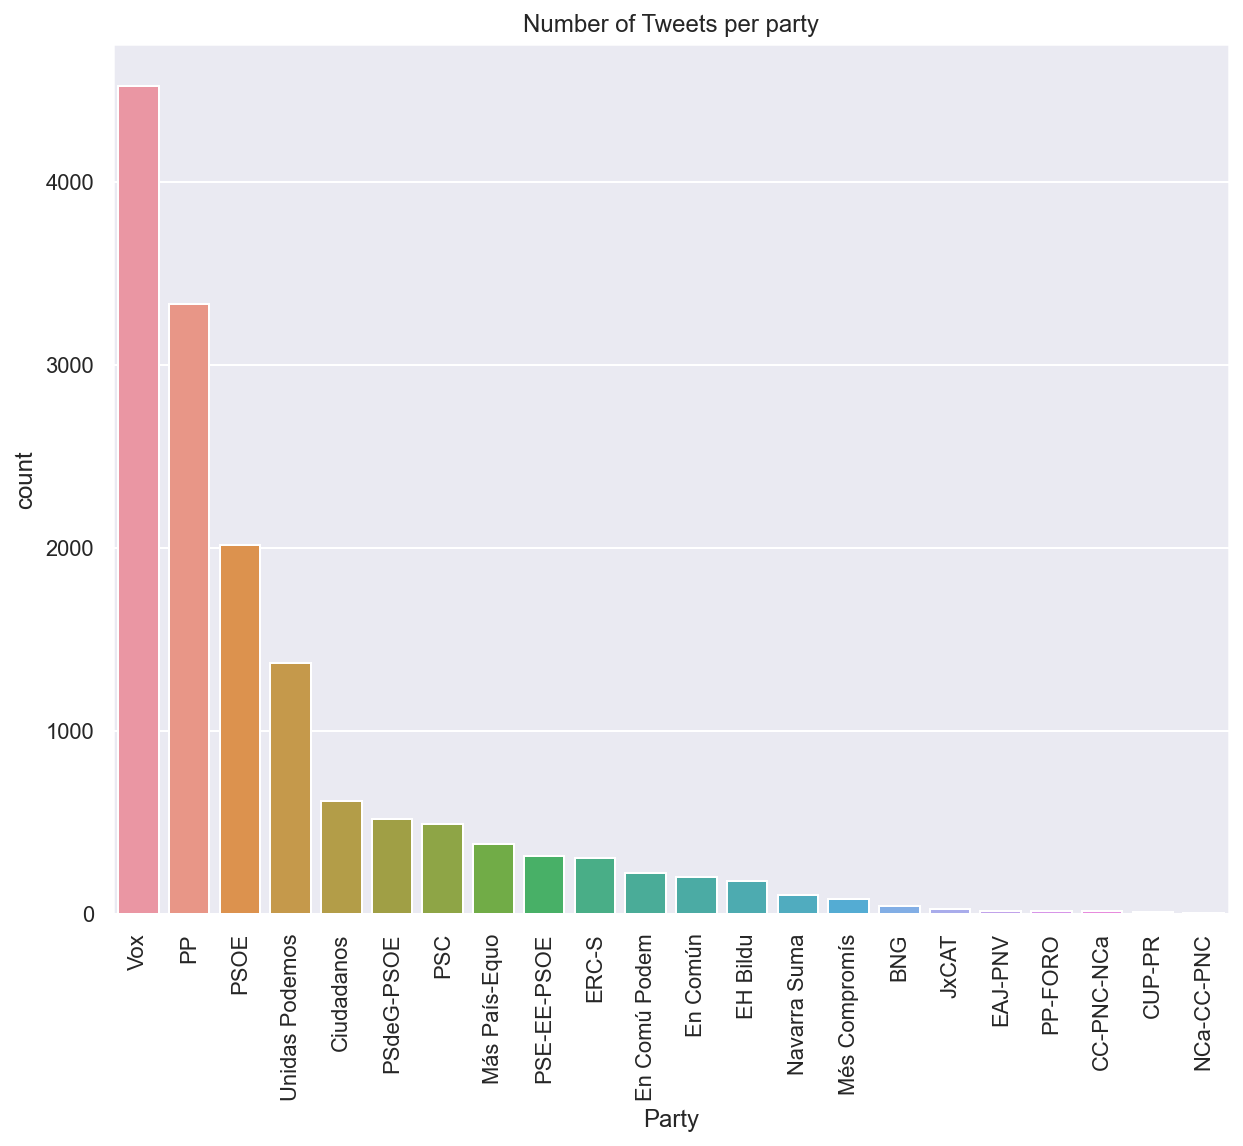

In [28]:
plt.figure()
sns.countplot(
    data=data, x="Party",
    order=data["Party"].value_counts().index
)
plt.xticks(rotation = 90)
plt.title("Number of Tweets per party")
plt.show()

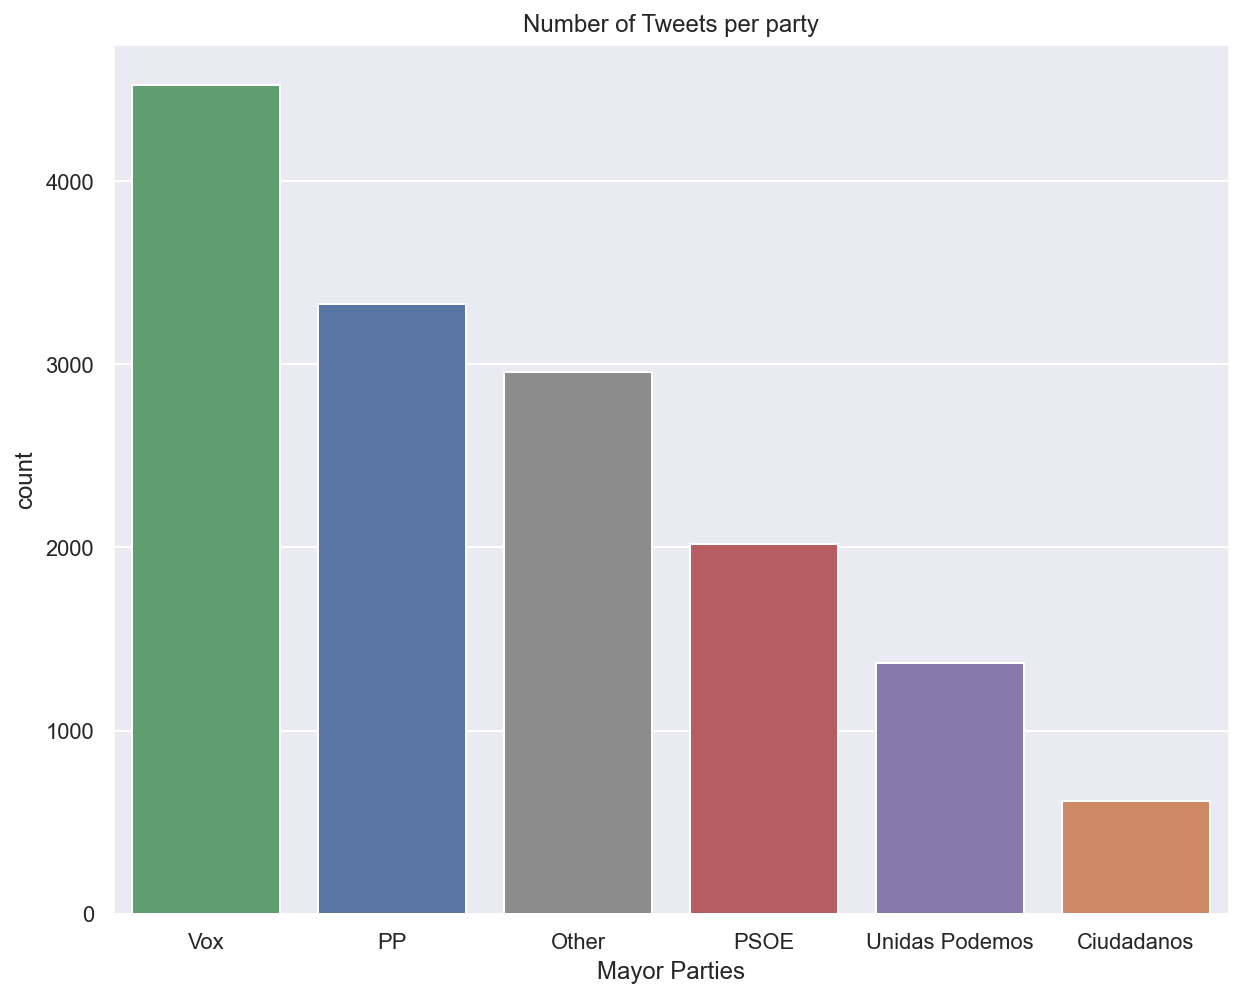

In [29]:
plt.figure()
sns.countplot(
    data=data, x="Mayor Parties",
    order=data["Mayor Parties"].value_counts().index,
    palette=color_assign
)
plt.title("Number of Tweets per party")
plt.show()

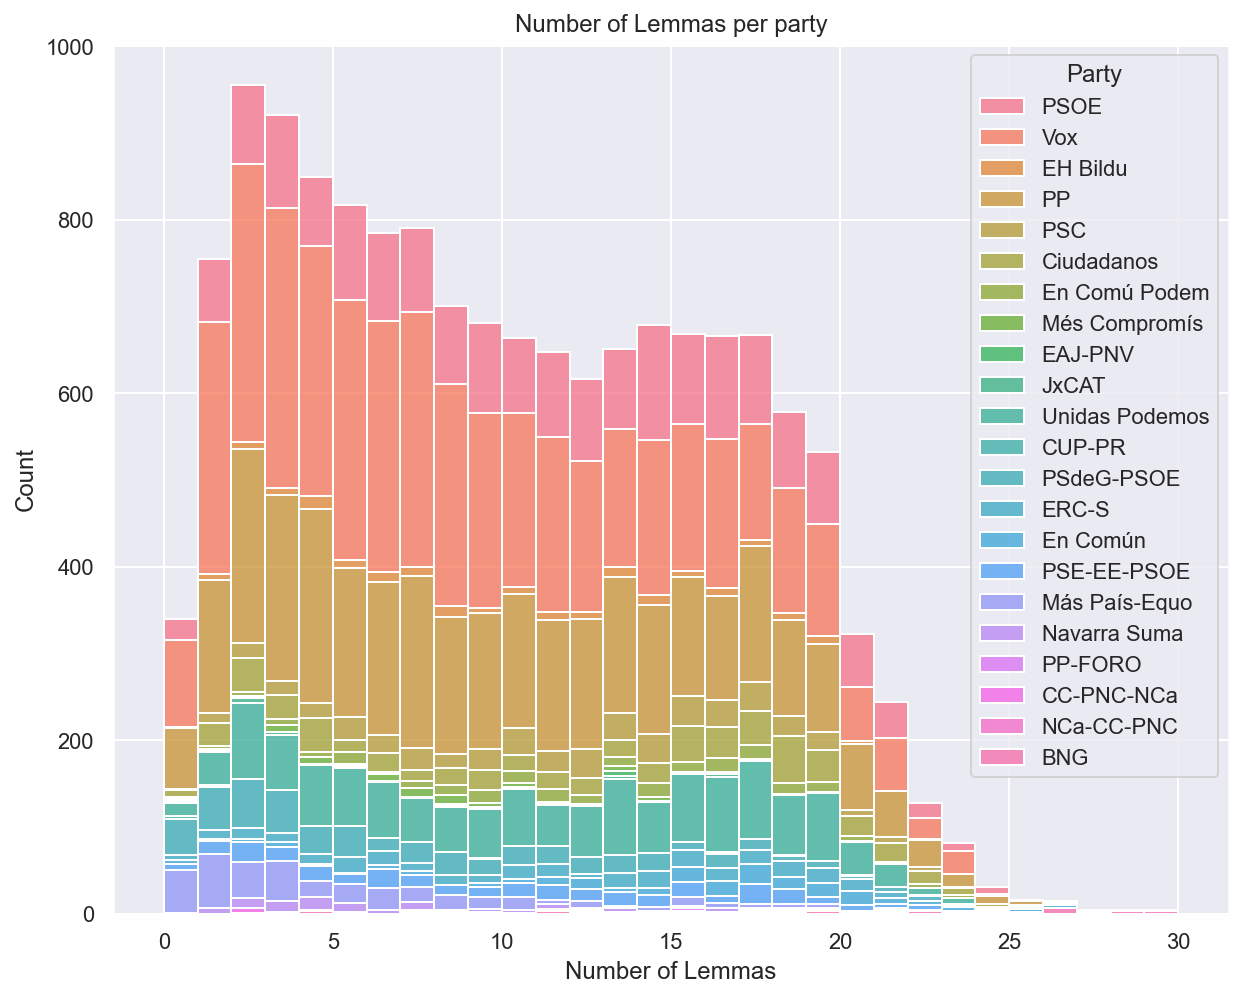

In [30]:
plt.figure()
sns.histplot(
    data=data,
    x="n_lemmas", hue="Party",
    multiple="stack", bins=30
)
plt.xlabel('Number of Lemmas')
plt.title("Number of Lemmas per party")
plt.show()

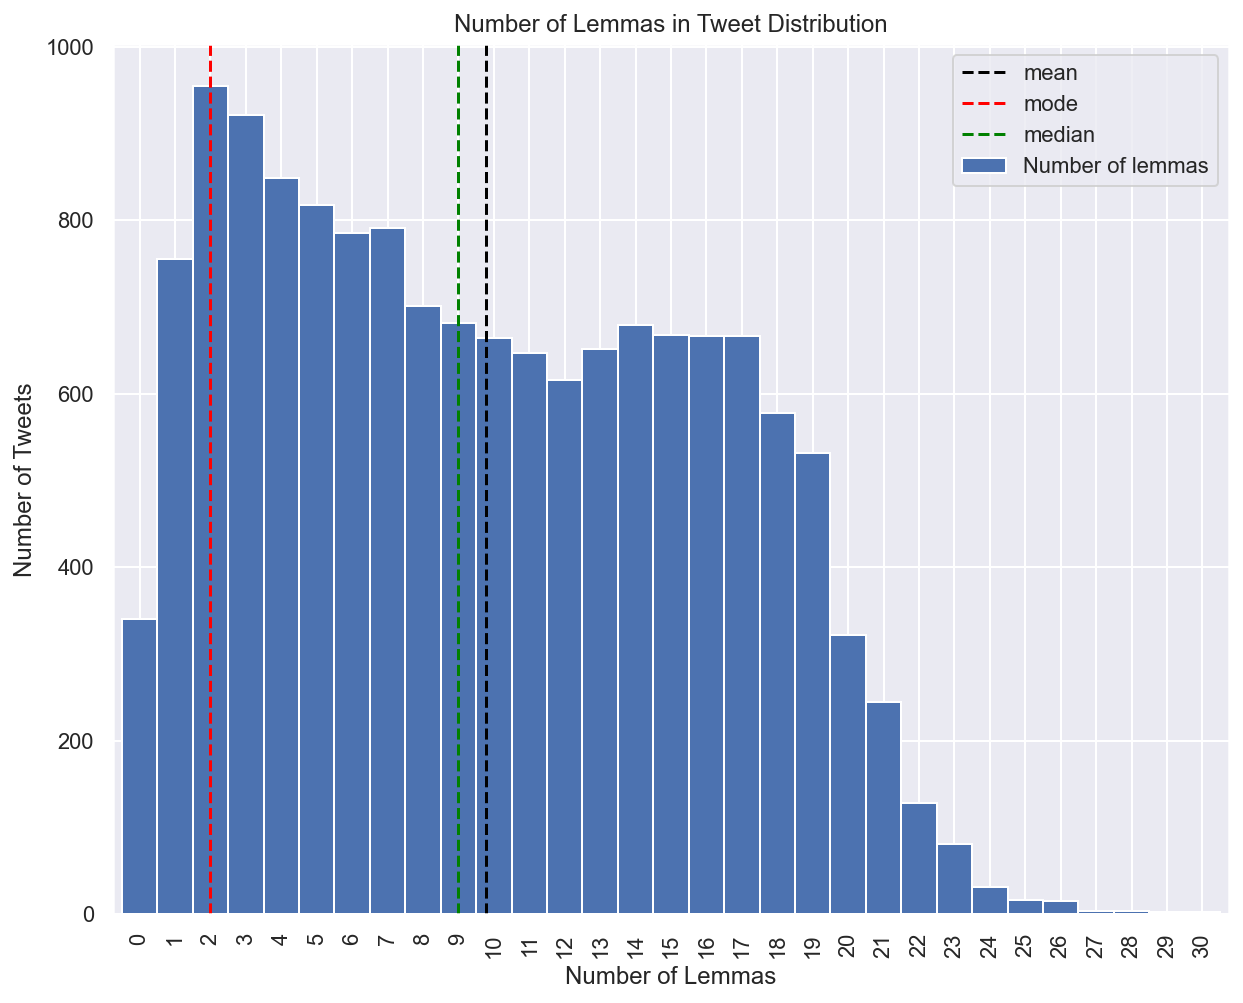

In [37]:
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(
    kind="bar",
    width=1,
    label='Number of lemmas'
)
plt.axvline(x=data['n_lemmas'].mean(),
            label='mean', color='black',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].mode()[0],
            label='mode', color='red',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].median(),
            label='median', color='green',
            linestyle = '--')
plt.legend()
plt.title('Number of Lemmas in Tweet Distribution')
plt.xlabel('Number of Lemmas')
plt.ylabel('Number of Tweets')
plt.show()

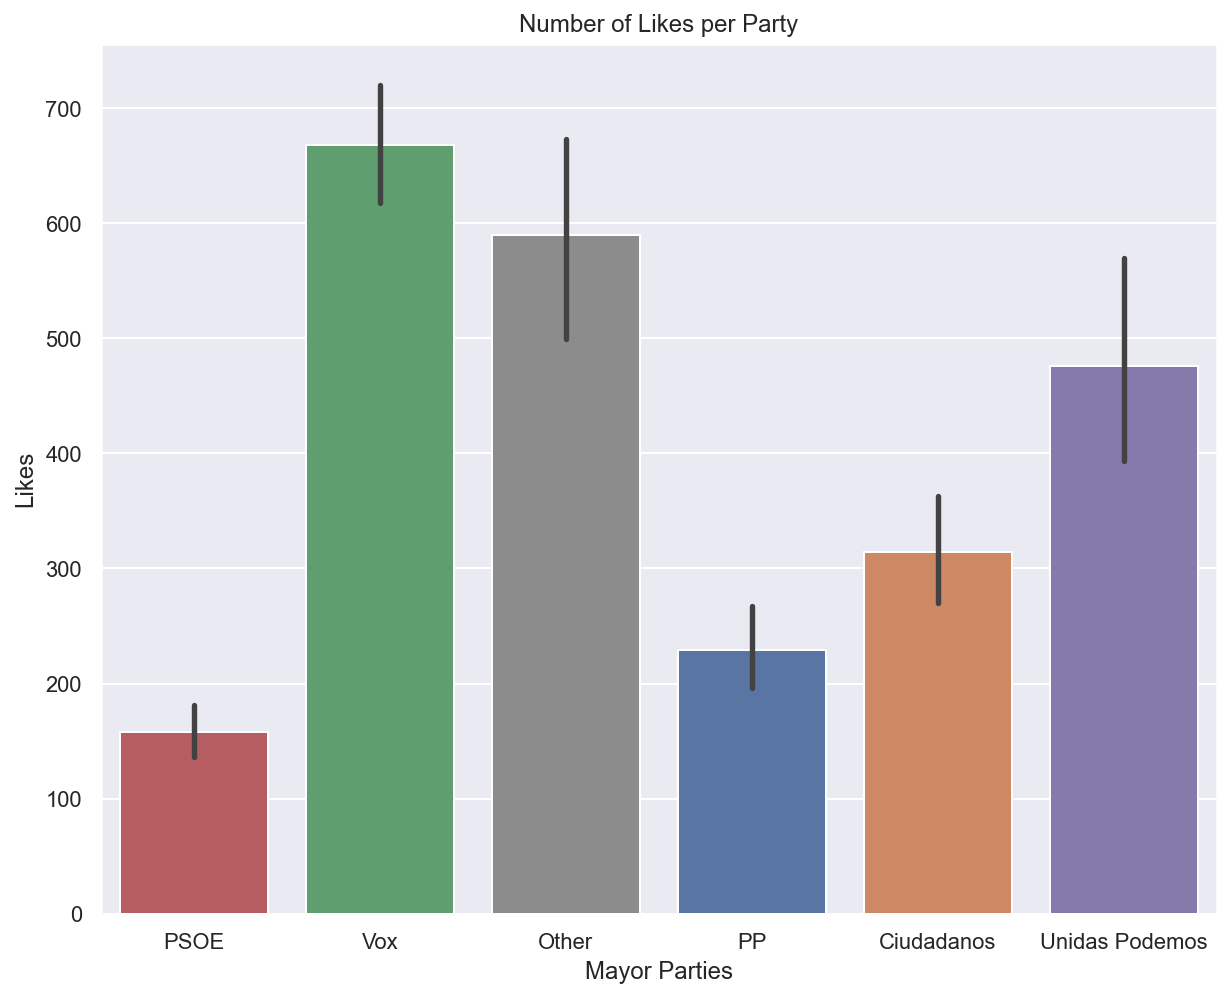

In [49]:
plt.figure()
sns.barplot(
    data=data, x='Mayor Parties', y='Likes',
    palette=color_assign
)
plt.title('Number of Likes per Party')
plt.show()

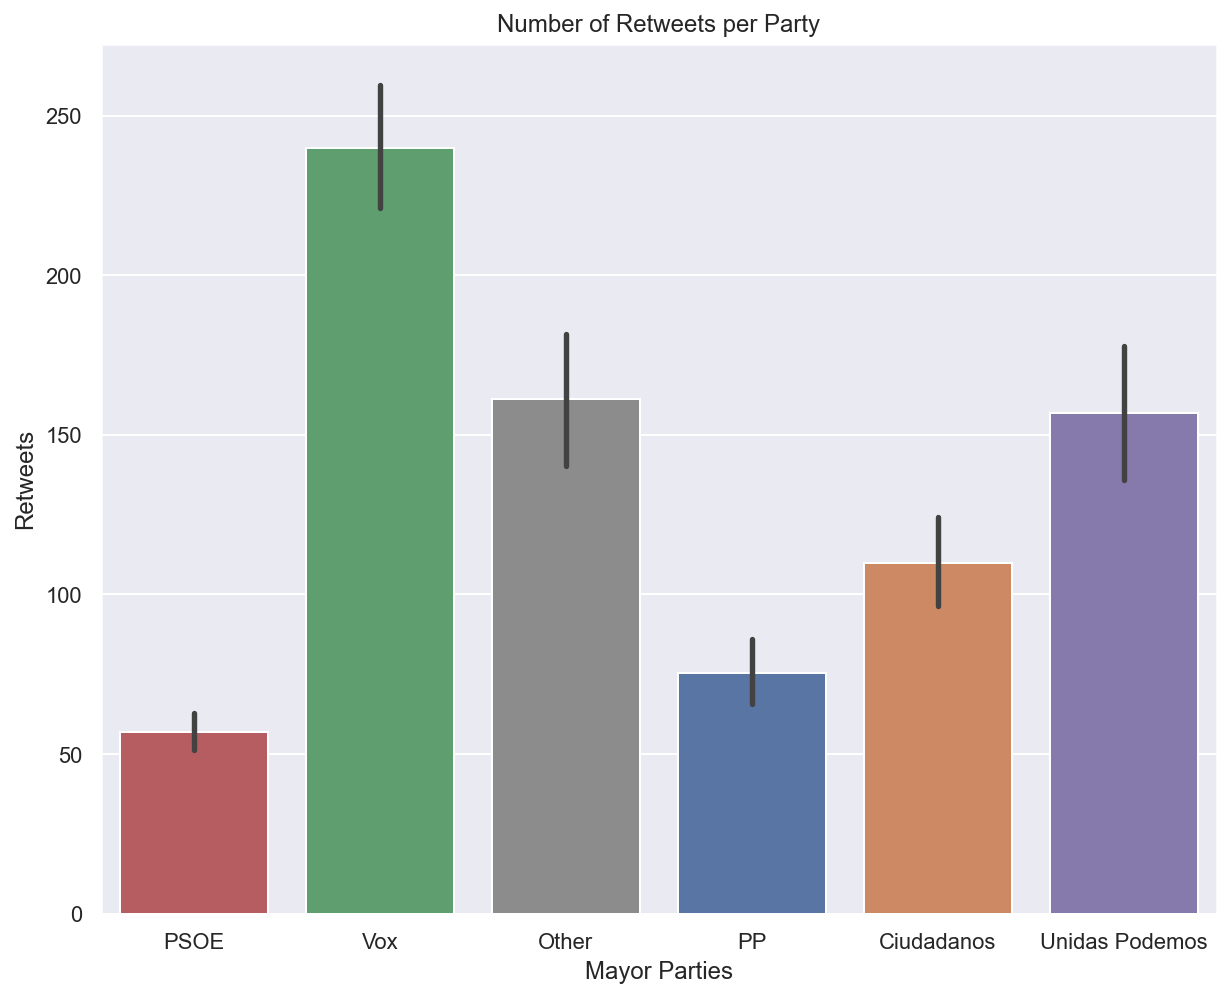

In [50]:
plt.figure()
sns.barplot(data=data, x='Mayor Parties', y='Retweets', palette=color_assign)
plt.title('Number of Retweets per Party')
plt.show()

# Parsing Lemmas

In [51]:
def remove_accents(sentence):
    parsed_sentence = []
    for word in sentence.split(" "):
        if "ñ" in word:
            parsed_sentence.append(word)
        else:
            parsed_sentence.append(unidecode(word))
    return " ".join(parsed_sentence)

In [6]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_accents(str(x).lower()))

In [14]:
data = data[data['n_lemmas'] >= 3]
print(f'Number of Tweets in Dataframe after removing short tweets: {len(data)}')

Number of Tweets in Dataframe after removing short tweets: 10209


# Creating the Corpus and Dictionary of terms

In [15]:
def from_df_to_token_dictionary(df, n_lemmas_threshold=3):
    
    df = df[df['n_lemmas'] >= n_lemmas_threshold]
    print(f'Number of Tweets in Dataframe after removing short tweets: {len(df)}')
    
    tweets_corpus = [el.split() for el in df["Lemmas"]]
    # display(tweets_corpus)
    
    df_copy = copy.copy(df)
    
    token_dic = Dictionary(tweets_corpus)
    return token_dic, tweets_corpus, df_copy

In [16]:
token_dict, tweets_corpus, _ = from_df_to_token_dictionary(data, n_lemmas_threshold=3)

Number of Tweets in Dataframe after removing short tweets: 10209


In [17]:
def create_word_freq(token_dic):
    word_freq = {}
    for k, v in token_dic.items():
        word_freq[v] = token_dic.cfs[k]

    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_word_freq

In [18]:
sorted_word_freq = create_word_freq(token_dict)
# print(sorted_word_freq)

# Plot and analysis of term Dictionary stuff

In [19]:
def plot_frequencies(collection):
    collfreq = sorted(collection.items()) 
    x, y = zip(*collfreq) 
    plt.plot(x, y)

In [20]:
def compute_token_mean_max(collection):
    count, _sum = 0, 0
    for key in collection:
        count += 1
        _sum += collection[key]
    
    instances_max = max(collection.values())
    instances_mean = _sum/count
    
    return instances_max, instances_mean

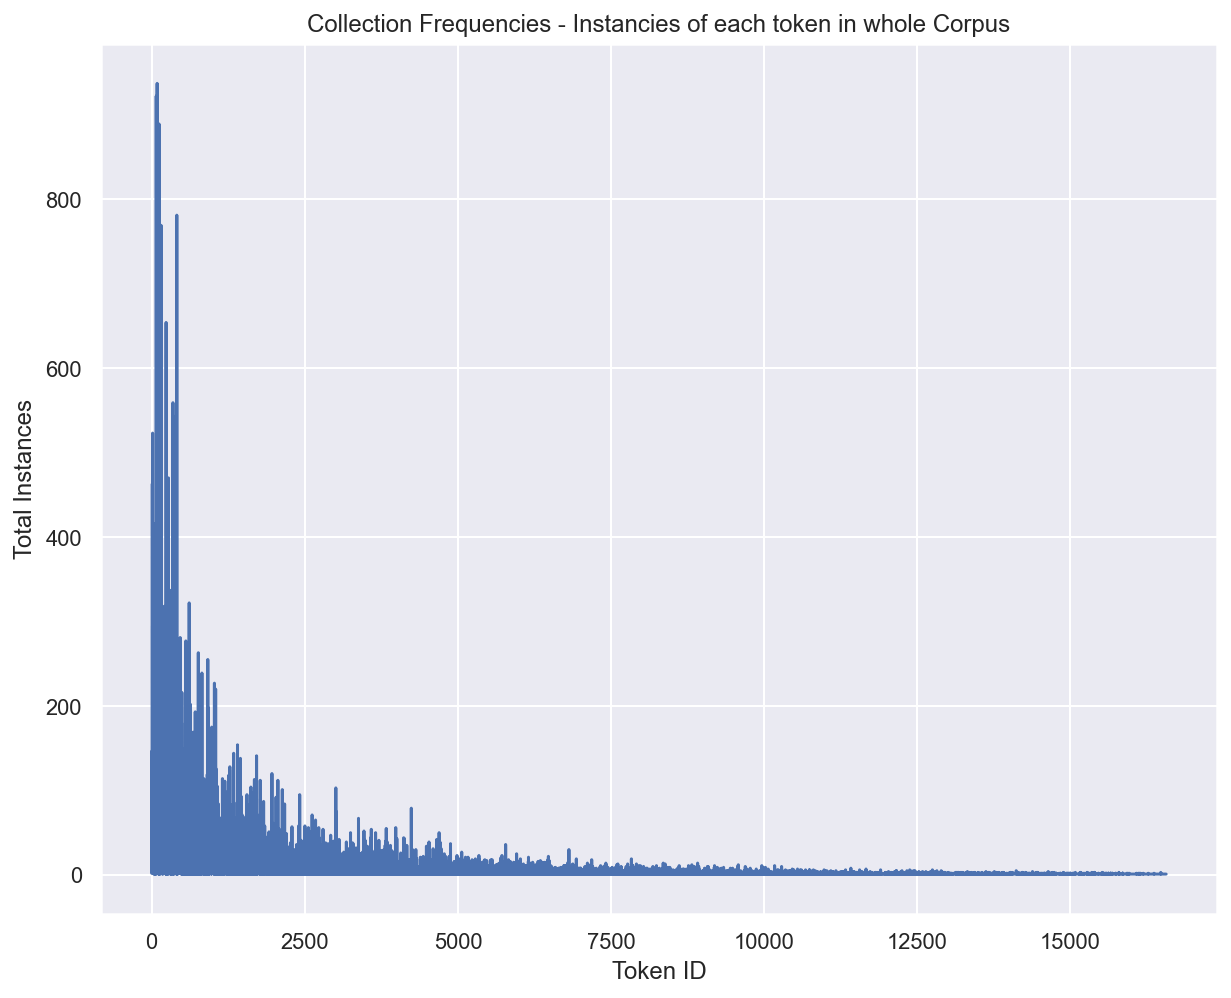

Max of occurances per topic: 937
Mean of occurances per topic: 6.8694680915293125


In [21]:
# Collection frequencies: token_id -> how many instances of this token are contained in the documents.
plot_frequencies(token_dict.cfs)
plt.title('Collection Frequencies - Instancies of each token in whole Corpus')
plt.xlabel('Token ID')
plt.ylabel('Total Instances')
plt.show()

instances_max, instances_mean = compute_token_mean_max(token_dict.cfs)

print(f"Max of occurances per topic: {instances_max}")
print(f"Mean of occurances per topic: {instances_mean}")

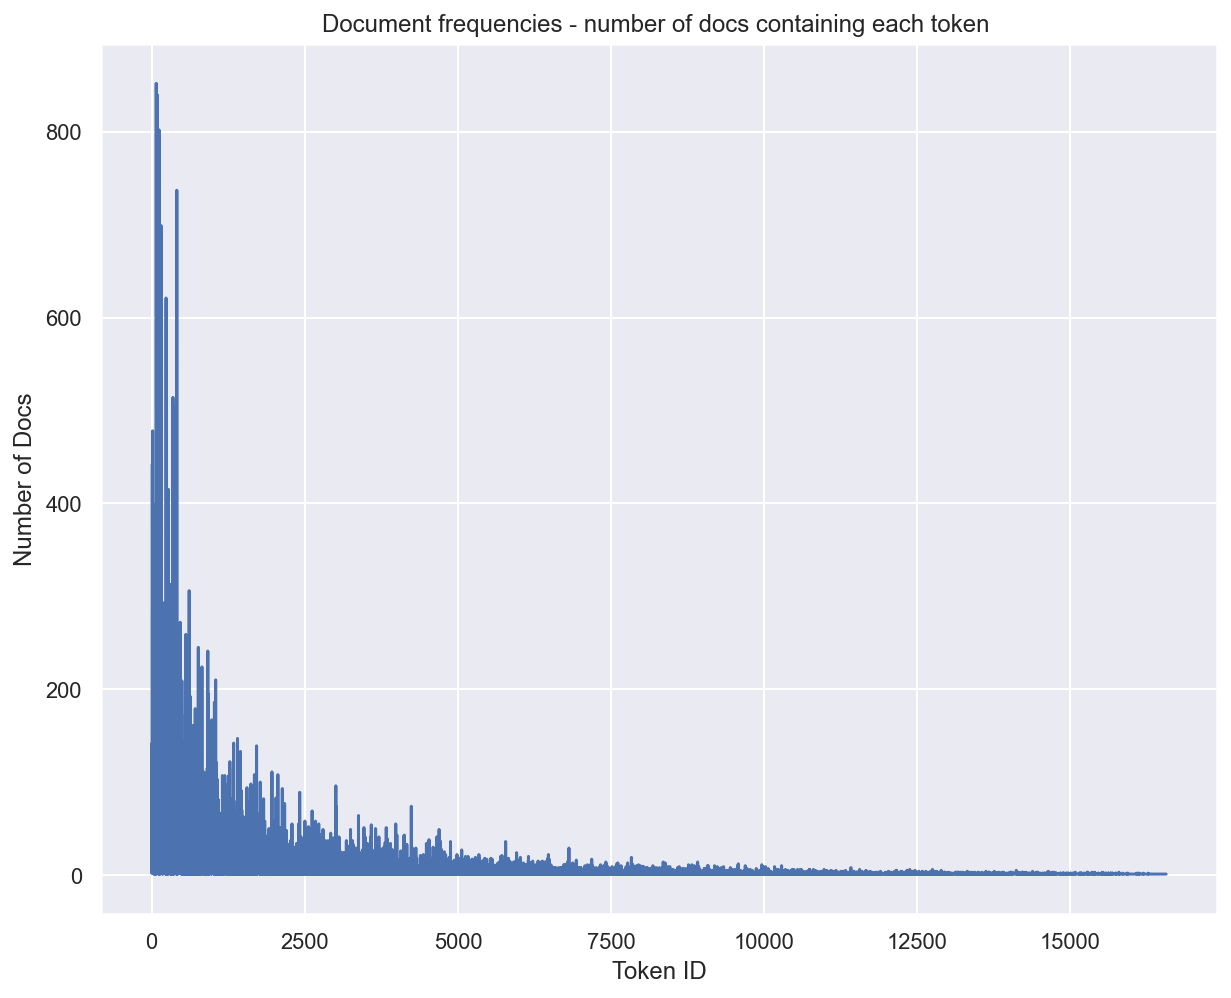

Max of docs in which a token appears: 852
Mean of docs in which token appears: 6.622532149972831


In [22]:
# Document frequencies: token_id -> how many documents contain this token
plot_frequencies(token_dict.dfs)
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('Token ID')
plt.ylabel('Number of Docs')
plt.show()

docs_max, docs_mean = compute_token_mean_max(token_dict.dfs)

print(f"Max of docs in which a token appears: {docs_max}")
print(f"Mean of docs in which token appears: {docs_mean}")

# Choosing hyperparameters for filtering extremes

In [23]:
def filter_dict_and_get_bow(token_dict, corpus, below=2, above=1):
    copy_dict = copy.copy(token_dict)
    copy_dict.filter_extremes(no_below=below, no_above=above)
    bow = [copy_dict.doc2bow(doc) for doc in corpus]
    return copy_dict, bow

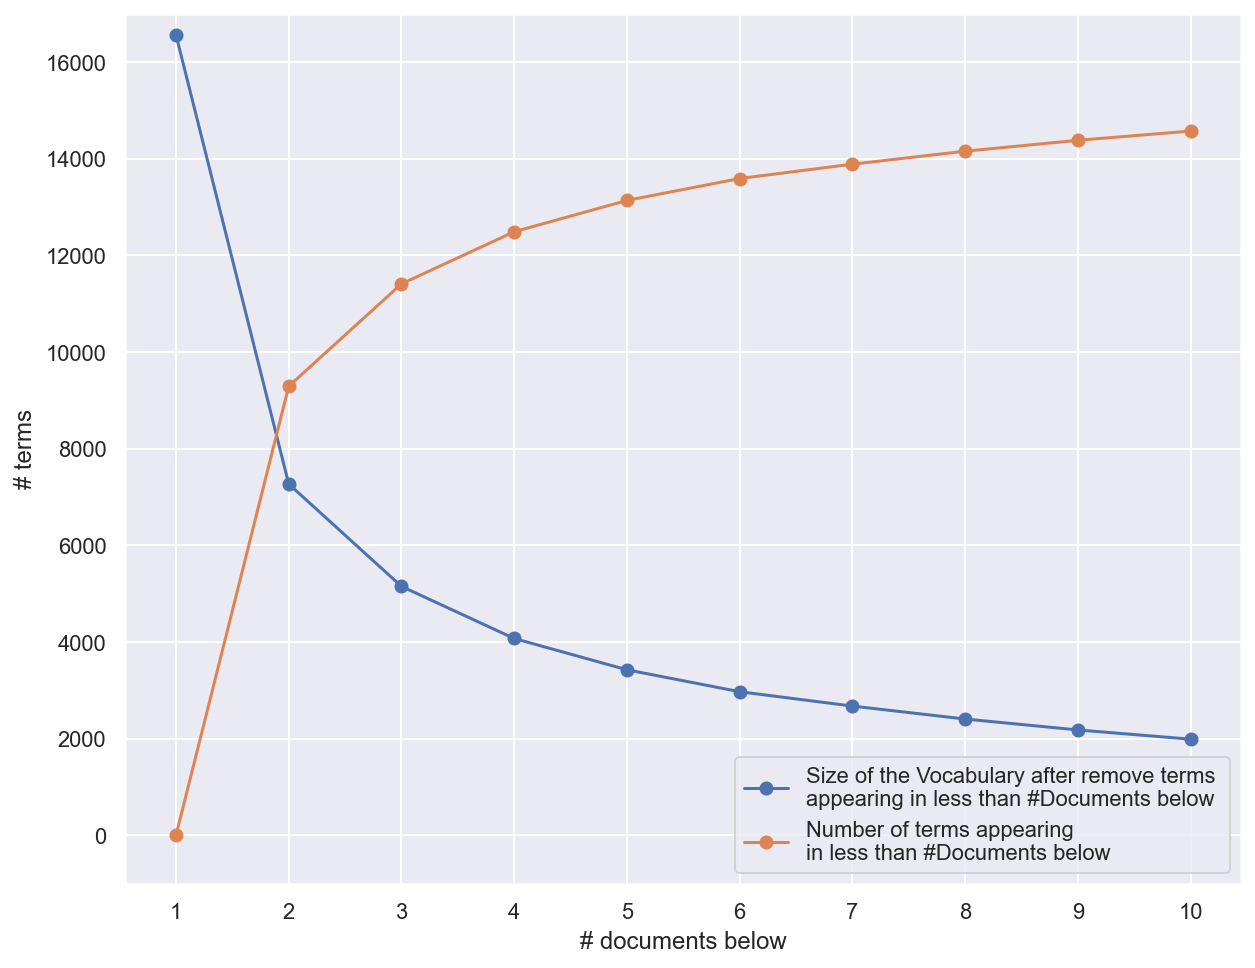

In [24]:
np.array([i[1] for i in sorted(token_dict.dfs.items())])
plt.plot(
    range(1,11),
    [len(token_dict) - np.sum(np.array([i[1] for i in sorted(token_dict.dfs.items())]) < i) for i in range(1,11)],
    'o-', label='Size of the Vocabulary after remove terms \nappearing in less than #Documents below'
)
plt.plot(
    range(1,11),
    [np.sum(np.array([i[1] for i in sorted(token_dict.dfs.items())]) < i) for i in range(1,11)],
    'o-', label = 'Number of terms appearing \nin less than #Documents below'
)
plt.xticks(range(1,11),range(1,11))
plt.xlabel('# documents below')
plt.ylabel('# terms')
plt.ylim(-1000,17000)
plt.legend()
plt.show()

# Obtaining BOW from filtered Dictionary

In [25]:
# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)
# filtered_dict = copy.copy(token_dict)

# filtered_dict = filter_dict(token_dict)
# tweets_bow = get_bow(token_dict, tweets_corpus)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)
tweets_corpus_tdidf = TfidfModel(tweets_corpus_bow)
print(f'The dictionary contains {len(filtered_dict)} terms')

The dictionary contains 7270 terms


# Applying LDA and Ploting it for visualization of terms in topics

In [26]:
import os
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = r'C:/mallet'
mallet_path = 'C:/mallet/bin/mallet'
# mallet_path = '/Users/bernardobouzas/Downloads/mallet-2.0.8/bin/mallet'

In [27]:
def compute_lda(corpus, token_dict, num_topics=15, alpha=5, iterations=100):
    ldamallet = LdaMallet(
        mallet_path,
        corpus=corpus,
        id2word=token_dict,
        num_topics=num_topics,
        alpha=alpha,
        iterations=iterations
    )
    return ldamallet

In [28]:
ldamallet = compute_lda(tweets_corpus_bow, filtered_dict, num_topics=15)

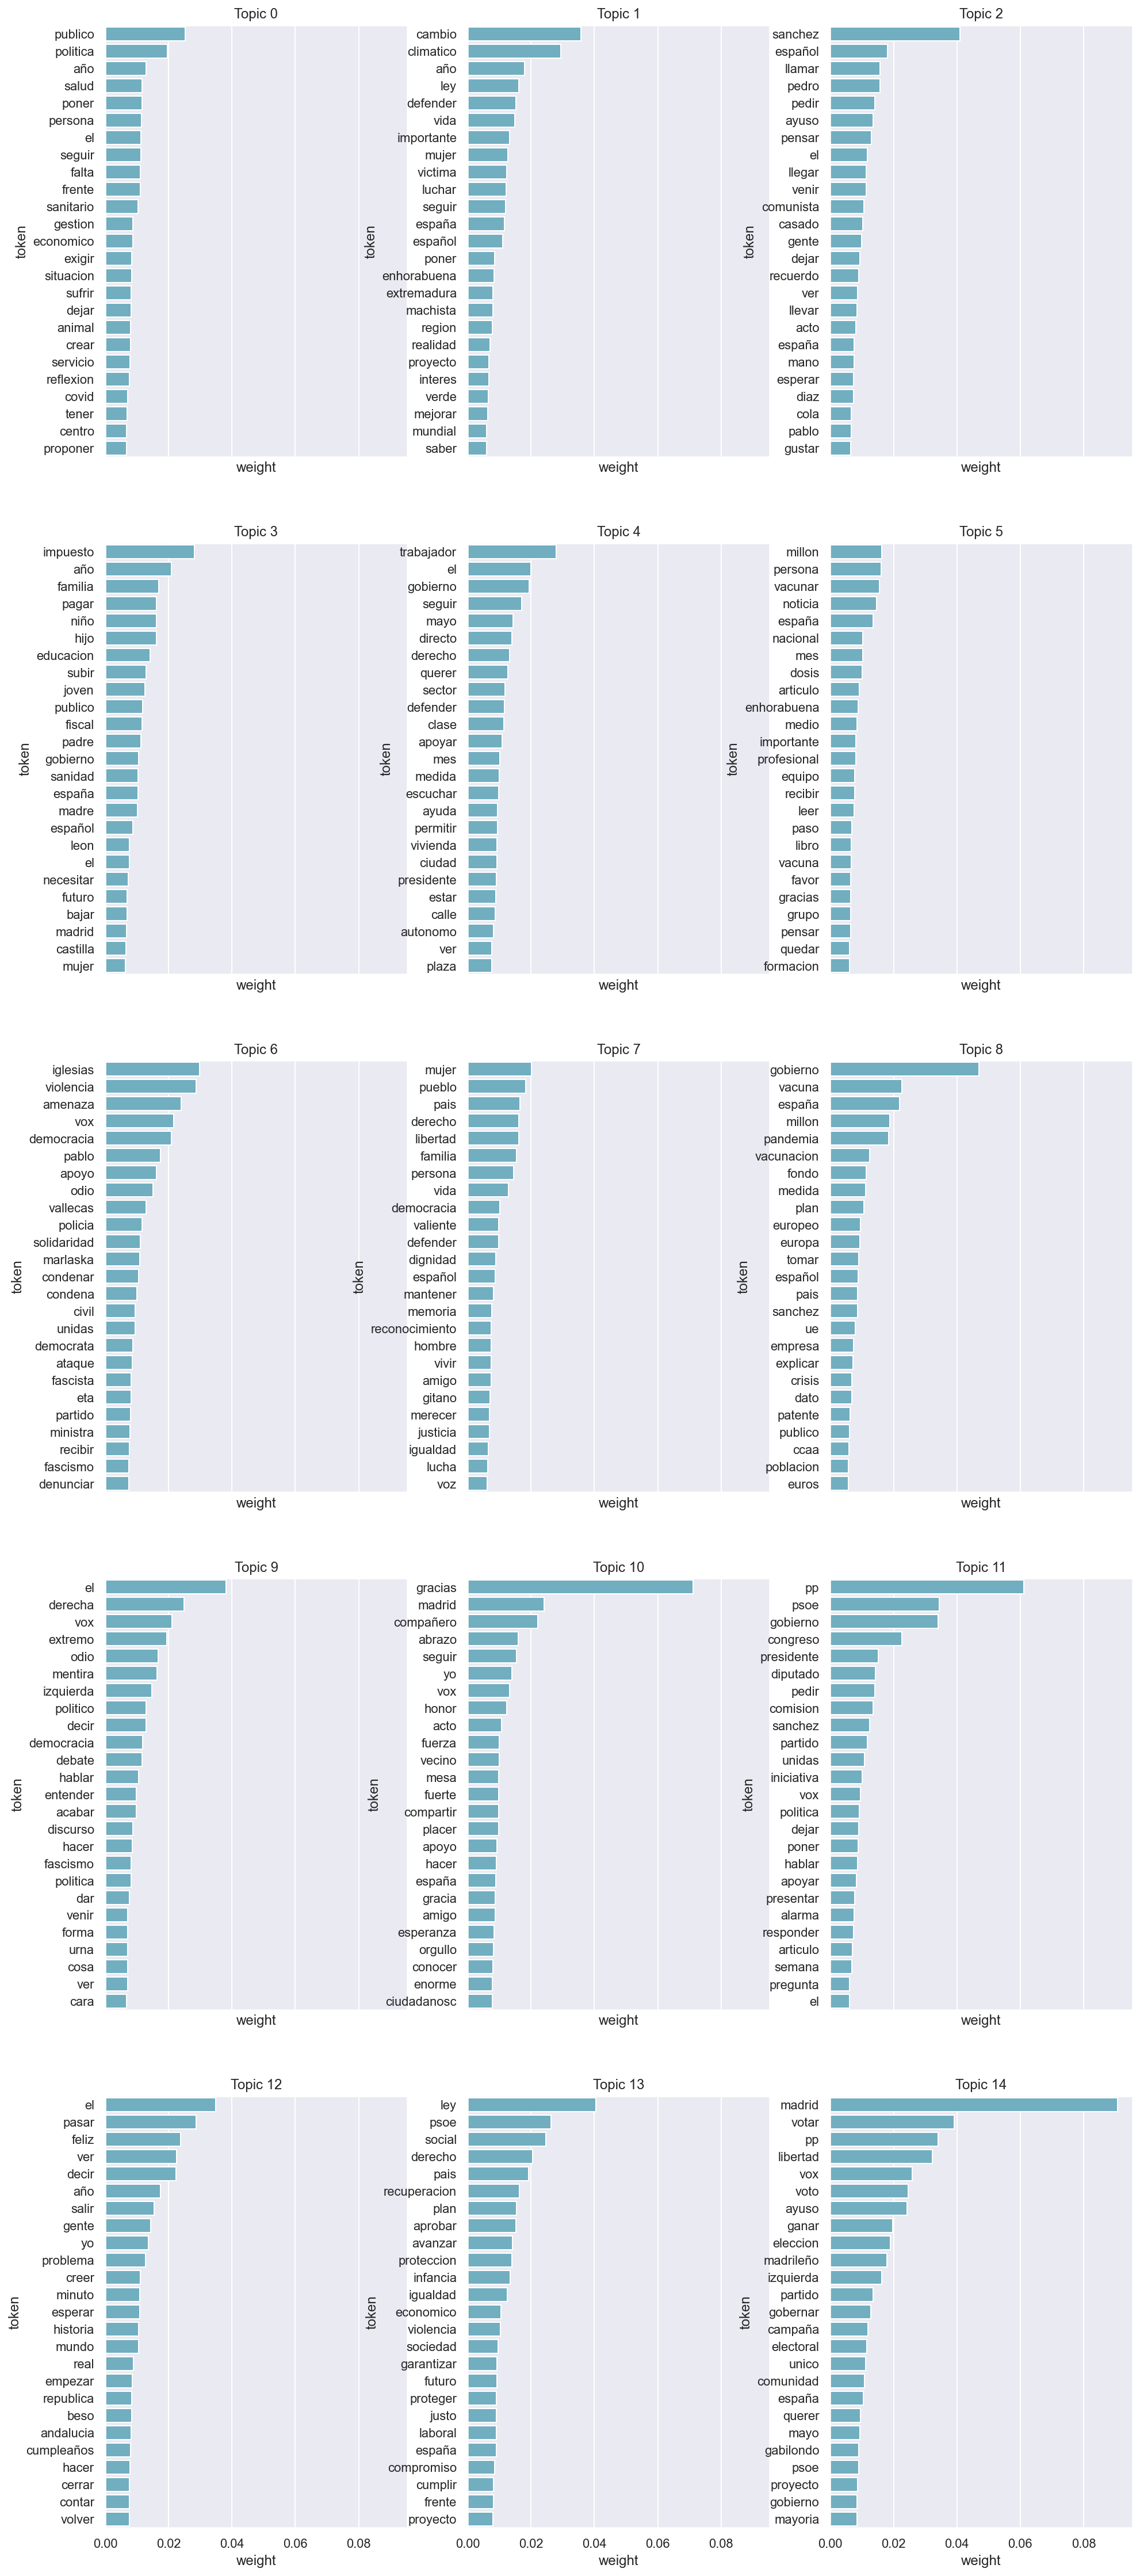

In [29]:
topn = 25
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 40), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%rows), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%rows)}')

plt.show()

# Specific stopword removal

In [30]:
specific_stw = [
    'el', 'año', 'vivir', 'hacer', 'plan',
    'sector', 'salir', 'gestion', 'resto',
    'ir', 'yo', 'ley', 'gobierno', 'serio',
    'nacional', 'acto', 'minuto', 'explicar',
    'estar', 'poner', 'discurso', 'pedir',
    'volver', 'alto', 'punto', 'pasar', 'pais',
    'dar', 'quedar', 'hablar', 'decir', 'dejar',
    'ver', 'paso', 'importante', 'aprobar', 'gente',
    'dato', 'llegar', 'politica', 'venir', 'leer',
    'seguir', 'entender', 'tener', 'llevar', 'convertir',
    'directo', 'partido', 'cara', 'caso', 'hilo', 'gracia',
    'favor', 'medio', 'forma', 'señor', 'empezar',
    "psoe", "pp", "vox", "ciudadanos", "unidas",
    "angel","pablo", "pedro","isabel",
    "español", "gracias", "españa",
    "cosa", "mirar", "tweet", "valor", "querer",
    "san", "utilizar", "ojo"
]


# specific_stw = ["psoe", "pp", "vox", "ciudadanos", "unidas"]

specific_stw = list(set([el.lower() for el in specific_stw]))

In [31]:
def remove_stpwrd(string, specific_stw_eliminate):
    splitted = string.split()
    resultwords = [word for word in splitted if word.lower() not in specific_stw_eliminate]
    return ' '.join(resultwords)

In [32]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_stpwrd(str(x), specific_stw))

data['n_lemmas'] =  data['Lemmas'].str.split().str.len()
#print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(NSF_df))

# Checking filtered results

Number of Tweets in Dataframe after removing short tweets: 9759


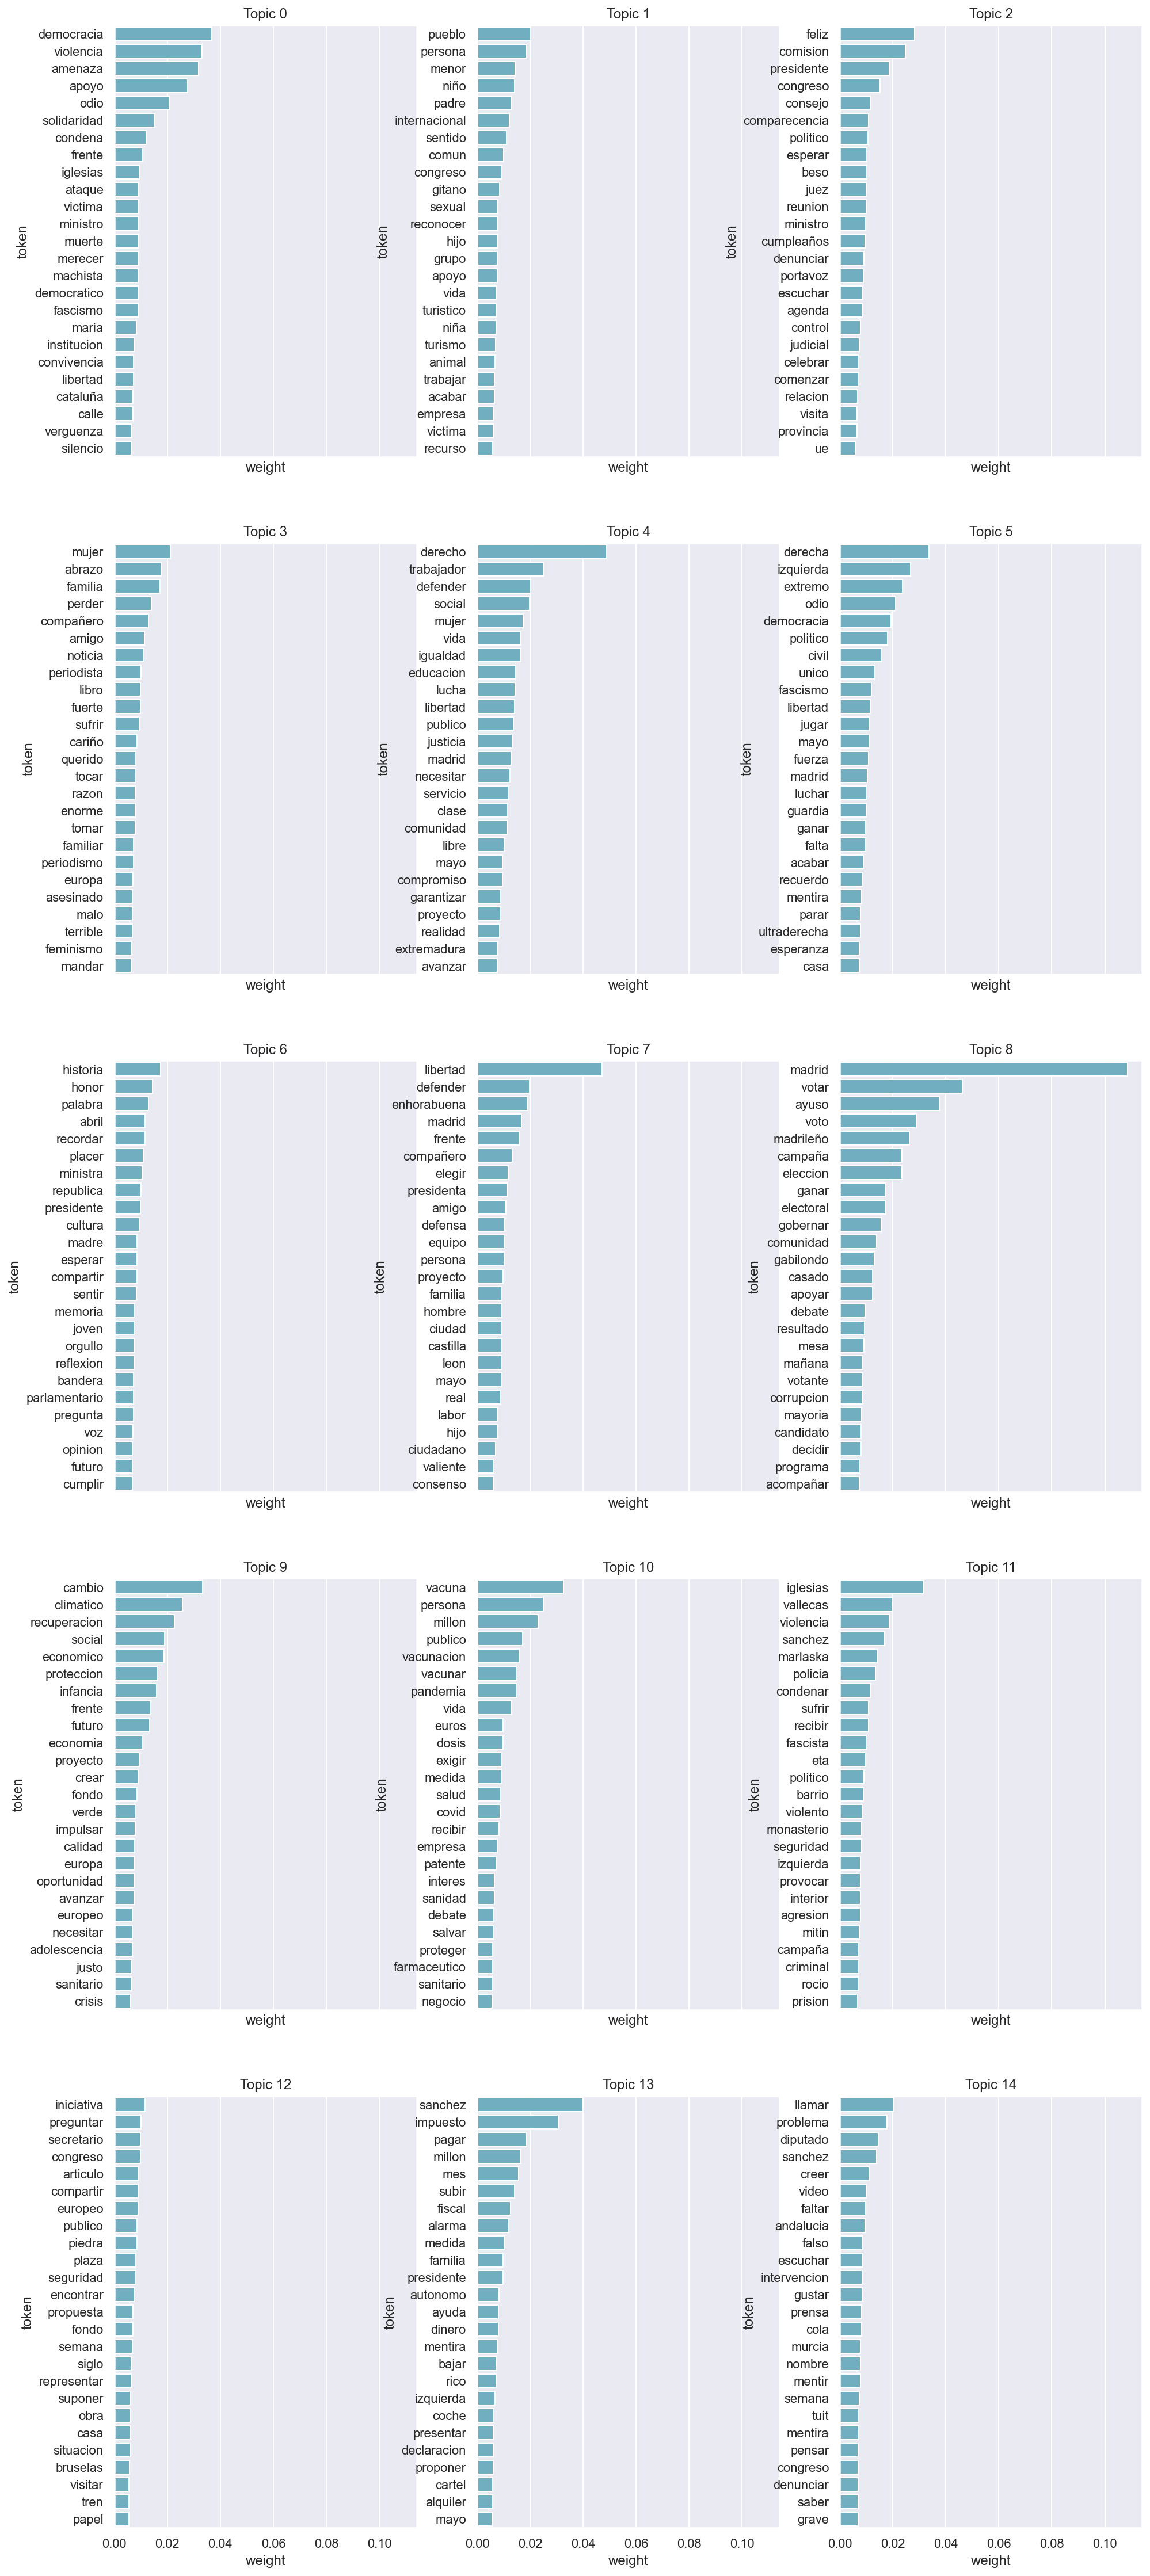

In [33]:
token_dict, tweets_corpus, _ = from_df_to_token_dictionary(data, n_lemmas_threshold=3)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)
ldamallet = compute_lda(tweets_corpus_bow, filtered_dict, num_topics=15)
topn = 25
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 40), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%rows), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%rows)}')

plt.show()

# Choosing hyperparameter number of topics

In [34]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [35]:
token_dict, tweets_corpus, _ = from_df_to_token_dictionary(data, n_lemmas_threshold=3)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)

Number of Tweets in Dataframe after removing short tweets: 9759


In [36]:
def compute_lda_coherence(corpus, corpus_bow, token_dict, min_topics=10, max_topics=120, step=10):
    
    topic_coherence = []
    for ntpc in range(min_topics, max_topics + 1, step):
        lda_ntcp = LdaModel(corpus=corpus_bow, id2word=token_dict, num_topics=ntpc)
        topic_coherence.append(
            CoherenceModel(
                lda_ntcp,
                texts=corpus,
                dictionary=token_dict,
                coherence='c_v').get_coherence()
        )
        print(f'Computed model with {ntpc} topics out of {max_topics//step}')
    
    return topic_coherence

# Checking topic coherence from 5 to 150 topics

In [37]:
# topic_coherence = compute_lda_coherence(tweets_corpus, tweets_corpus_bow, filtered_dict, 5,150,15)

# n_topics = range(5, 150, 15)
# plt.figure()
# plt.plot(n_topics, topic_coherence)
# plt.xticks(n_topics, n_topics)
# plt.xlabel('Number of Topics')
# plt.ylabel('Average Coherence')
# plt.show()

# Fine tuning coherence from 3 to 25 topics

In [38]:
# topic_coherence = compute_lda_coherence(tweets_corpus, tweets_corpus_bow, filtered_dict, 3,25,4)

# n_topics = range(3, 25, 4)
# plt.figure()
# plt.plot(n_topics, topic_coherence)
# plt.xticks(n_topics, n_topics)
# plt.xlabel('Number of Topics')
# plt.ylabel('Average Coherence')
# plt.show()

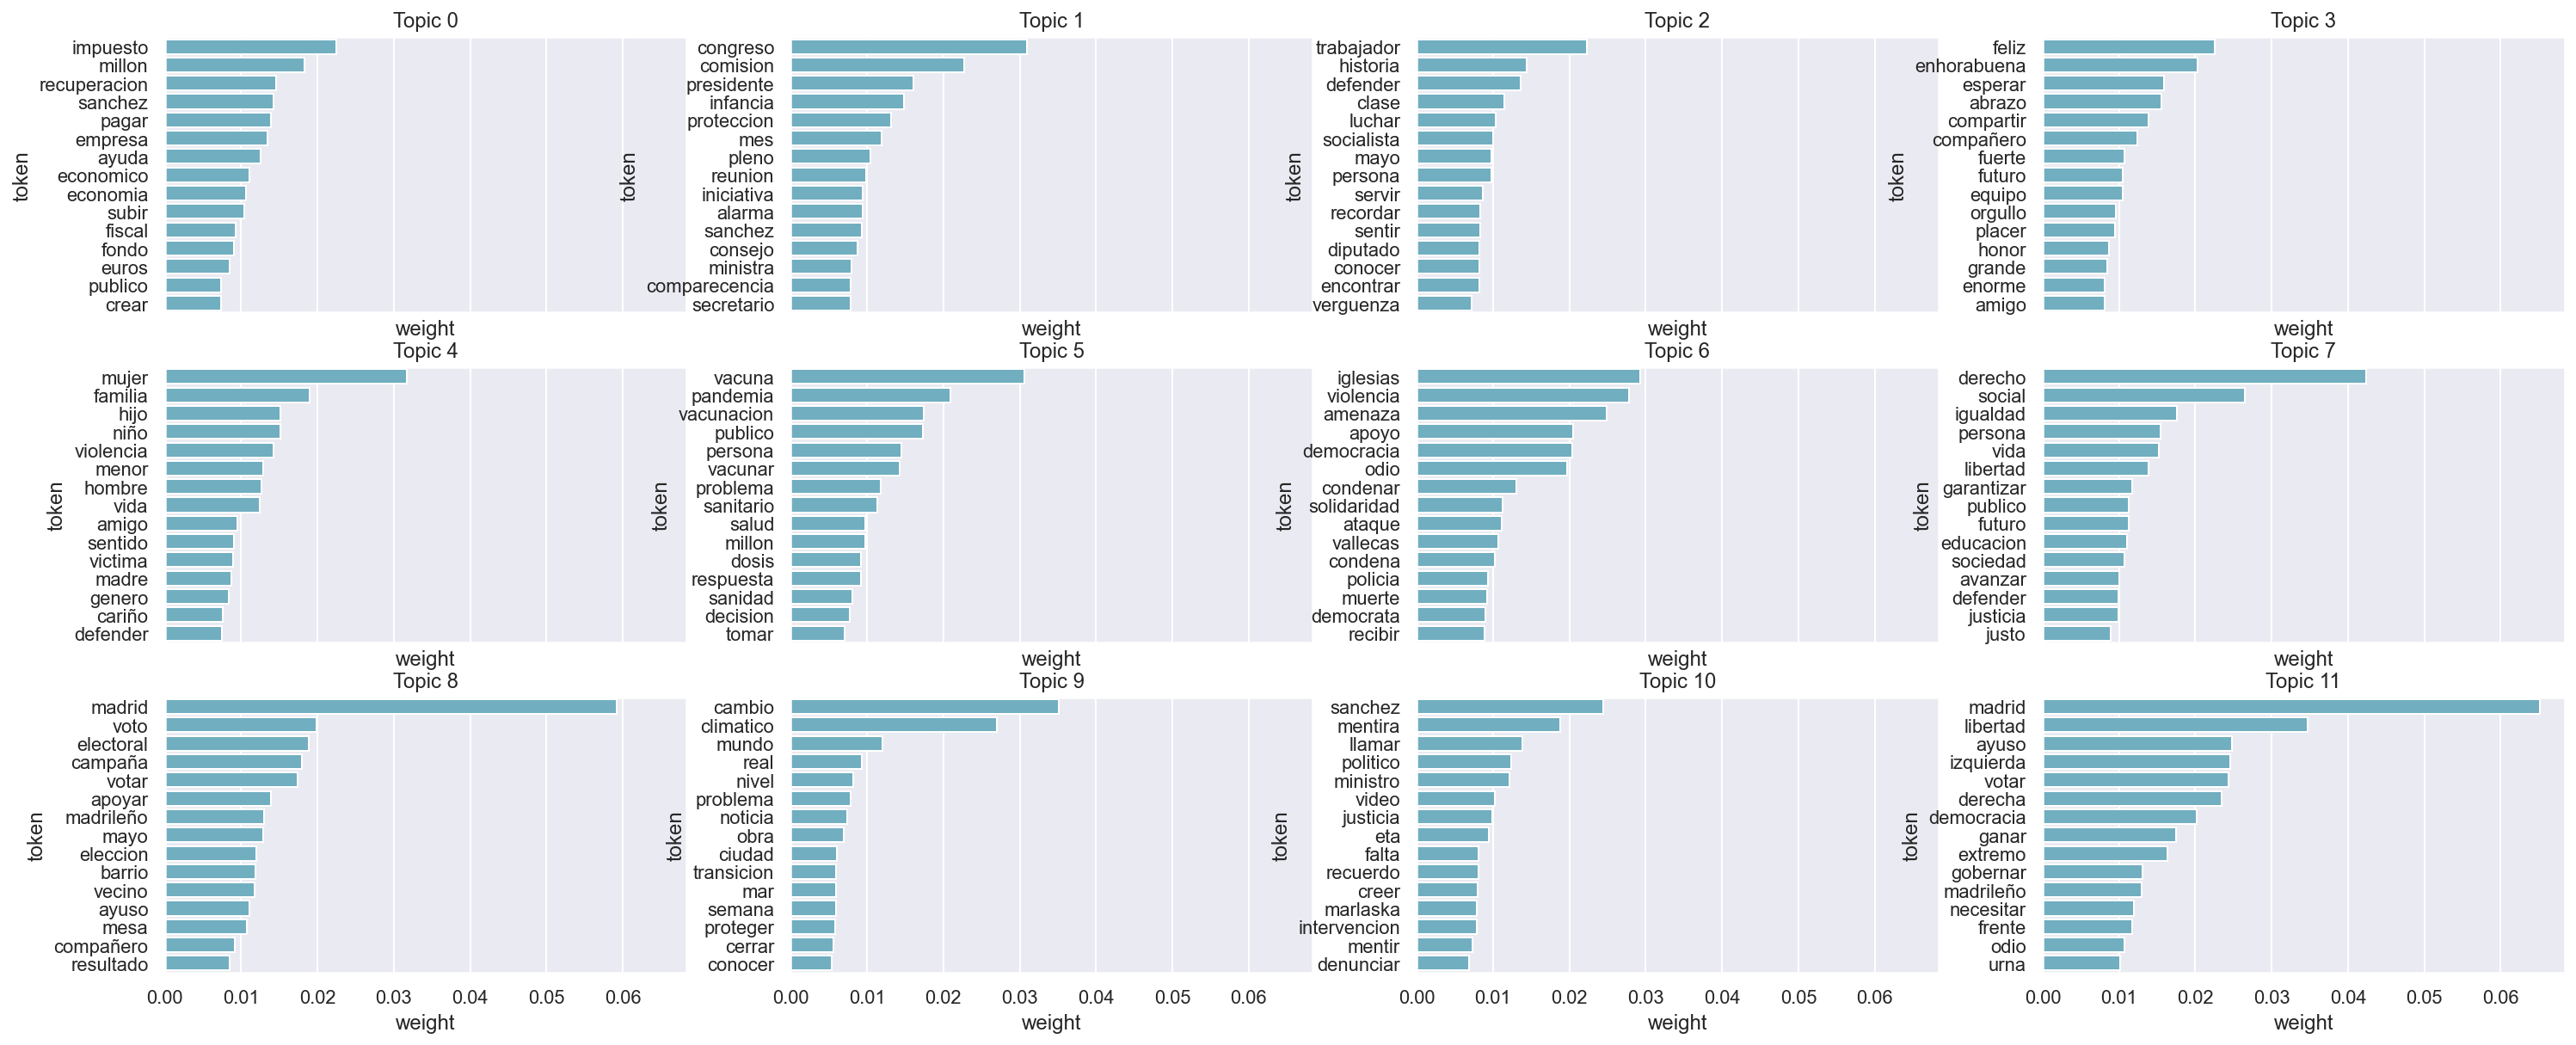

In [39]:
import pickle

ldamallet = pickle.load(open("ldamodel.p", "rb"))
topn = 15
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(25, 10), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%rows), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%rows)}')

plt.show()

# Definitive LDA model, we are saving it in a pickle

In [40]:
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
import pyLDAvis
from pyLDAvis.gensim_models import prepare

In [41]:
ldamallet = pickle.load(open("ldamodel.p", "rb"))

ldagensim = malletmodel2ldamodel(ldamallet)
#vis_data = prepare(ldagensim, tweets_corpus_bow, filtered_dict)
#pyLDAvis.display(vis_data)

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# tpc_descriptions = []

# for ntpc in range(12):
#     print(ldagensim.show_topic(ntpc, topn=20))
#     desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
#     tpc_descriptions.append(desc)

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# print(tpc_descriptions)
# pickle.dump(tpc_descriptions, open("topic_descriptions.p", "wb"))

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
tpc_descriptions = pickle.load(open("topic_descriptions.p", "rb"))

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:

token_dict, tweets_corpus, df = from_df_to_token_dictionary(data, n_lemmas_threshold=3)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)
lda_12_topics = [ldagensim[el] for el in tweets_corpus_bow]


rec = []
for topic in lda_12_topics:
    rec.append([value[1] for value in topic])


    
topic_dict= {f"Topic{k}": [] for k in range(12)}
lst = []
for i in lda_12_topics:
    for k, v in i:
        
        topic_dict[f"Topic{k}"] += [v]

main_topic = [tpc_descriptions[sorted(el,key=lambda x: -x[-1])[0][0]] for el in lda_12_topics]


c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of Tweets in Dataframe after removing short tweets: 9759


In [46]:
final_df = pd.DataFrame()

final_df["Original_tweet"] = df.sort_index()["Original Tweets"]
final_df["Main_topic"] = main_topic

for k,v in topic_dict.items():
    final_df[k] = v


final_df["LDA_12"] = lda_12_topics 


final_df['Likes'] = df.sort_index()["Likes"].to_list()
final_df['Retweets'] = df.sort_index()["Retweets"].to_list()
final_df["Author"] = df.sort_index()["Author"].to_list()
final_df["Party"] = df.sort_index()["Party"].to_list()
mayor_5_parties = final_df['Party'].value_counts().index[:5]
final_df['Mayor Parties'] = final_df['Party'].apply(lambda x: x if x in mayor_5_parties else 'Other')
final_df.columns = ["Original_tweet", "Main_topic", *tpc_descriptions, "LDA_12", "Likes", "Retweets", "Author", "Party","Mayor Parties"]
final_df

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Original_tweet,Main_topic,Tax increase plan for the European Union,I Congress on Childhood and Adolescence,Working class defense,Congratulations and culture,Discrimination to minorities and victims,Evolution of the vaccination plan and pandemic situation,Threats to left-wing,Society's values,Madrid elections (citizen participation),Climate change,Threats to the welfare state,Madrid elections (candidacies),LDA_12,Likes,Retweets,Author,Party,Mayor Parties
1,Día de homenaje a los españoles deportados y f...,Congratulations and culture,0.263733,0.161247,0.024437,0.268555,0.056484,0.024121,0.024855,0.081025,0.026100,0.023148,0.023148,0.023148,"[(0, 0.263732511109953), (1, 0.161247072539100...",770,326,José Luis Ábalos Meco,PSOE,PSOE
2,Mi agradecimiento a los interventores y apoder...,Tax increase plan for the European Union,0.217557,0.179726,0.092219,0.045731,0.019637,0.131476,0.019512,0.099341,0.019504,0.091338,0.064494,0.019465,"[(0, 0.21755727307814537), (1, 0.1797261323499...",653,222,José Luis Ábalos Meco,PSOE,PSOE
3,Hemos autorizado las obras de un puente móvil ...,Madrid elections (citizen participation),0.020833,0.020921,0.042979,0.171769,0.077564,0.078122,0.075834,0.021894,0.268298,0.020833,0.180120,0.020833,"[(0, 0.020833333333374966), (1, 0.020920658441...",167,77,José Luis Ábalos Meco,PSOE,PSOE
5,Se cumplen 142 años de la fundación del @PSOE ...,Tax increase plan for the European Union,0.279660,0.024992,0.083333,0.134904,0.024834,0.174111,0.024510,0.141137,0.025497,0.036982,0.024510,0.025530,"[(0, 0.2796600957795382), (1, 0.02499194773861...",421,211,José Luis Ábalos Meco,PSOE,PSOE
7,Junto con los sindicatos @UGT_Comunica y @CCOO...,Threats to the welfare state,0.021930,0.021930,0.021930,0.022465,0.023577,0.021930,0.142229,0.025063,0.022362,0.021983,0.632396,0.022206,"[(0, 0.02192982456140863), (1, 0.0219298245614...",352,136,José Luis Ábalos Meco,PSOE,PSOE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14806,🔴La política de inmigración del Gobierno es pu...,Congratulations and culture,0.034722,0.034722,0.116354,0.267043,0.038173,0.036423,0.035737,0.196969,0.034722,0.034722,0.132027,0.038384,"[(0, 0.03472222222223755), (1, 0.0347222222222...",11,6,Ana María Zurita Expósito,PP,PP
14808,🔵Los diputados canarios del @GPPopular hemos r...,Working class defense,0.026630,0.026042,0.271890,0.026500,0.139850,0.027886,0.043235,0.028718,0.217199,0.026281,0.026042,0.139728,"[(0, 0.02662957461087797), (1, 0.0260416666666...",7,6,Ana María Zurita Expósito,PP,PP
14809,🔵Ayer mantuvimos una reunión con @pp_icod para...,Madrid elections (candidacies),0.021008,0.346152,0.019841,0.019841,0.019841,0.028850,0.020567,0.068983,0.019849,0.062777,0.019867,0.352423,"[(0, 0.021007750414962313), (1, 0.346152377256...",4,4,Ana María Zurita Expósito,PP,PP
14810,"📻 Mañana, a partir de las 10:00h, participo en...",Threats to left-wing,0.037879,0.037879,0.037879,0.037879,0.186435,0.037879,0.389569,0.055185,0.037879,0.037879,0.039194,0.064464,"[(0, 0.037878787878821964), (1, 0.037878787878...",10,4,Ana María Zurita Expósito,PP,PP


In [47]:
import openpyxl

final_df.to_excel('data/final_tm_df.xlsx', index=False)

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
final_tm_df = pd.read_excel('data/final_tm_df.xlsx')

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of non-zero components in similarity matrix: 95238081
We check the size of the similarity matrix: (9759, 9759)
Ratio of non-zero components: 1.0


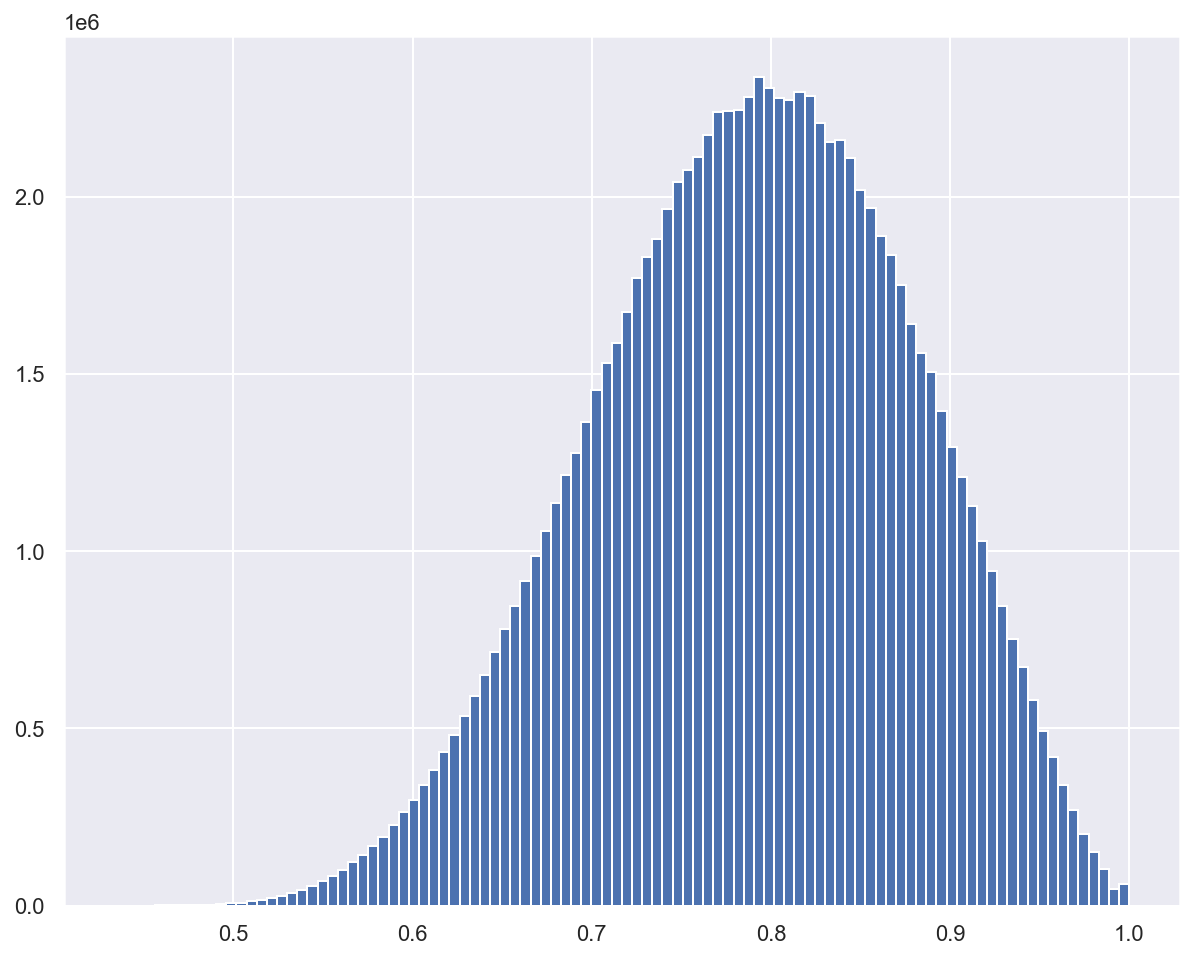

In [52]:
from gensim.matutils import corpus2csc
from scipy.sparse import triu
from ast import literal_eval

sample_size = len(final_tm_df)
corpus_size = len(final_tm_df)
sample_factor = sample_size / corpus_size

X = [literal_eval(el) for el in final_tm_df.sample(sample_size)['LDA_12'].values.tolist()]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)
#simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part

print('Number of non-zero components in similarity matrix:', len(simmat.data))
print('We check the size of the similarity matrix:', simmat.shape)
print('Ratio of non-zero components:', len(simmat.data)/simmat.shape[0]/simmat.shape[1])

plt.hist(simmat.data, bins=100)
plt.show()

In [53]:
thr = 0.6
simmat.data = np.where(simmat.data > thr, 0, simmat.data)
simmat.eliminate_zeros()
len(simmat.data)
print('Estimated number of links in full corpus:', len(simmat.data)/2/sample_factor**2)

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Estimated number of links in full corpus: 858424.0


In [54]:
sample_size = 2000
print('Creating a graph with', sample_size, 'nodes')
final_tm_df_sample = final_tm_df.sample(sample_size)
final_tm_df_sample['Id'] = [el for el in np.arange(sample_size)]
final_tm_df_sample[['Id', 'Likes', 'Retweets', 'Author', 'Party', 'Main_topic']].to_csv('data/final_tm_nodes.csv', index=False)

Creating a graph with 2000 nodes


c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
X = [literal_eval(el) for el in final_tm_df_sample['LDA_12'].values.tolist()]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)
simmat.data = np.where(simmat.data > thr, 0, simmat.data)
simmat.eliminate_zeros()
simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part
print('Number of links in sampled corpus:', len(simmat.data))
simmat = simmat.tocoo()

Number of links in sampled corpus: 38000


c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
pd.DataFrame([el for el in zip(simmat.row.tolist(),simmat.col.tolist(),simmat.data.tolist())],
             columns=['Source','Target','Weight']).to_csv('data/final_tm_edges.csv', index=False)

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
